In [1]:
from nnModel import getModel

model = getModel()
# print(model.summary())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
from nnTrainingSession import NNTrainingSession
from nnTrainingGraph import plotNNTrainingSession

session = NNTrainingSession(model)

In [8]:
session.doTrain(num_loops=1, numGamesPerLoop=2,numEpochs=1)

Finished loading 2 training files and 10 validation files
Train on 120 samples, validate on 594 samples
Epoch 1/1
120/120 [==============================] - 0s 225us/step - loss: 9.5148 - policy_loss: 2.0167 - value_loss: 0.7498 - policy_acc: 0.8833 - value_acc: 0.5333 - val_loss: 9.0299 - val_policy_loss: 2.9105 - val_value_loss: 0.6119 - val_policy_acc: 0.6263 - val_value_acc: 0.6212


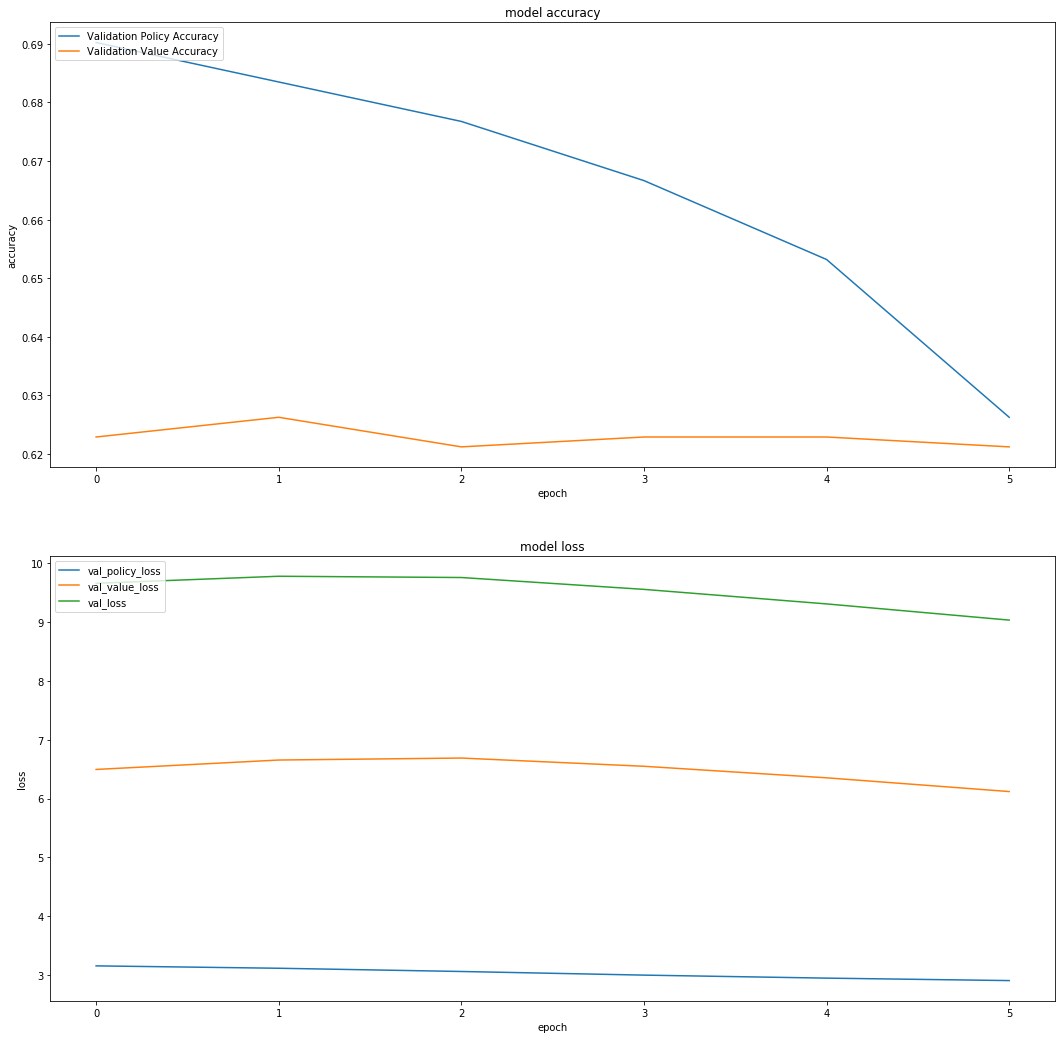

In [9]:
plotNNTrainingSession(session)